In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from tqdm import tqdm
import os
from joblib import dump
import matplotlib.pyplot as plt


In [2]:

data = pd.read_csv('data/lucene-3.0.0.csv')
data = data.drop('File', axis=1)
X = data.iloc[:, 0:]  # independent columns
y = data.iloc[:, -1]  # target column i.e Realbug


In [3]:
# # apply SelectKBest class to extract top 10 best features
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# # concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns, dfscores], axis=1)
# featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
# print(featureScores.nlargest(10, 'Score'))  #print 10 best features

In [4]:

import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = data.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
# plt.show()

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    corr_list = {}
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                corr_list[colname] = abs(corr_matrix.iloc[i, j])
    return col_corr, corr_list

corr_features, corr_list = correlation(data, 0.9)
len(set(corr_features))

import operator
sorted_features = sorted(corr_list.items(),key=operator.itemgetter(1),reverse=True)
print(sorted_features)

[('ADEV', 1.0), ('CountDeclMethod', 0.9997774449885828), ('SumCyclomatic', 0.9975255264611735), ('MAJOR_COMMIT', 0.9938305022683863), ('CountSemicolon', 0.9931087240559218), ('AvgLine', 0.9903139604124959), ('CountLineCode', 0.9881147626189772), ('CountStmt', 0.9857126367230075), ('AvgCyclomatic', 0.9679237143588031), ('CountStmtExe', 0.9657797786053655), ('AvgCyclomaticStrict', 0.9654336399751163), ('MaxCyclomaticStrict', 0.9641647004062414), ('CountLineCodeExe', 0.9486788738097273), ('CountStmtDecl', 0.9202264028149544), ('CountDeclMethodPublic', 0.9170690687318072), ('SumEssential', 0.915985110394307), ('AvgLineComment', 0.9146316360438366), ('SumCyclomaticModified', 0.9116577169350455), ('CountDeclInstanceMethod', 0.905019458529566)]


<Figure size 1440x1440 with 0 Axes>

In [5]:
## Load Data and preparing datasets
train_dataset = pd.read_csv(('data/lucene-2.9.0.csv'), index_col = 'File')
test_dataset = pd.read_csv(('data/lucene-3.0.0.csv'), index_col = 'File')

outcome = 'RealBug'

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes
class_labels = ['Clean', 'Defective']

In [6]:
# Feature Selection

###################
k_select = 10
###################

# features = list(featureScores.nlargest(10, 'Score').iloc[:k_select, 0])
features = [a[0] for a in sorted_features[:k_select]]

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

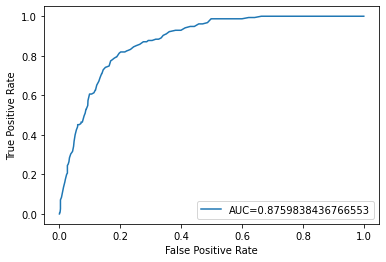

In [8]:
from sklearn import metrics
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Local Feature Attributions

In [9]:
# Only run the explainers on test files predicted as buggy
test_pred_buggy = np.where(rf_model.predict_proba(X_test) == 1)[0]
X_to_explain = X_test.iloc[test_pred_buggy]
files_to_be_explained = X_to_explain.index

## LIME

In [10]:
# Import for LIME
import lime
import lime.lime_tabular

# The model takes a DataFrame as input while LIME will fead a numpy array as input.
# Hence, the black-box we send to LIME must convert back to a DataFrame
black_box = lambda x : rf_model.predict_proba(pd.DataFrame(x, columns=features))

# Construct a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                        training_data=X_train.to_numpy(), 
                        mode='classification',
                        feature_names=features, 
                        class_names=["Clean", "Defect"], random_state=42
                    )

all_lime_exp = []
for file_to_be_explained in tqdm(files_to_be_explained, desc="Running LIME"):
    # Get local approximation around this instance
    instance = X_test.loc[file_to_be_explained]
    all_lime_exp.append(lime_explainer.explain_instance(
                                            instance, 
                                            black_box, 
                                            num_features=k_select, 
                                            num_samples=1000, 
                                            labels=(0, 1))
                                        )

# Save
explain_file = f"temp_results/LIME_k={k_select}.joblib"
dump(all_lime_exp, explain_file)

Running LIME: 100%|███████████████████████████| 174/174 [01:21<00:00,  2.14it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'temp_results/LIME_k=10.joblib'

## SHAP

In [11]:
import shap

# Use all files predicted as clean to form the background
clean_train = rf_model.predict(X_train)==0
background = X_train[clean_train]

# We explain the conditional probability
black_box = lambda x : rf_model.predict_proba(x)[:, 1]

# Run the model-agnostic Permutation explainer
shap_explainer = shap.explainers.Permutation(black_box, masker=background)
all_shap_exp = shap_explainer(X_to_explain)

# One model per dataset to explain (the best one according to CV)
explain_file = f"temp_results/SHAP_k={k_select}.joblib"
dump(all_shap_exp, explain_file)

Permutation explainer: 175it [00:57,  2.60it/s]                                 


FileNotFoundError: [Errno 2] No such file or directory: 'temp_results/SHAP_k=10.joblib'

## BreakDown

In [12]:
import dalex as dx

exp = dx.Explainer(rf_model, X_train[clean_train], y_train[clean_train])
all_breakdown_exp = []
for _, instance in tqdm(X_to_explain.iterrows()):
    breakdown = exp.predict_parts(instance, type='break_down', order=features)
    all_breakdown_exp.append(breakdown)

explain_file = f"temp_results/BreakDown_k={k_select}.joblib"
dump(all_breakdown_exp, explain_file)

Preparation of a new explainer is initiated

  -> data              : 1096 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1096 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fee2fdd8f70> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.0587, max = 0.494
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.494, mean = -0.0578, max = 0.506
  -> model_info        : package sklearn

A new explainer has been created!


174it [01:11,  2.42it/s]


['temp_results/BreakDown_k=10.joblib']

## PyExplainer

In [13]:

def parse_top_rules(positive_rules, negative_rules):
    """Parse top k positive rules and top k negative rules given positive and negative rules as DataFrame

    Parameters
    ----------
    positive_rules : :obj:`pandas.core.frame.DataFrame`
        Top positive rules DataFrame
    negative_rules : :obj:`pandas.core.frame.DataFrame`
        Top negative rules DataFrame

    Returns
    -------
    :obj:`dict`
        A dict feature and their respective local importance
    """

    variable_importance = {}

    # Iterate though the positive rules
    for i in range(len(positive_rules)):
        tmp_rule = (positive_rules['rule'].iloc[i])
        tmp_rule = tmp_rule.strip()
        tmp_rule = str.split(tmp_rule, '&')
        for j in tmp_rule:
            j = j.strip()
            tmp_sub_rule = str.split(j, ' ')
            tmp_variable = tmp_sub_rule[0]
            tmp_condition_variable = tmp_sub_rule[1]
            tmp_value = tmp_sub_rule[2]
            if tmp_variable not in variable_importance.keys():
                variable_importance.update(
                    {tmp_variable: positive_rules['importance'].iloc[i]}
                    )

    # Iterate though the negative rules
    for i in range(len(negative_rules)):
        tmp_rule = (negative_rules['rule'].iloc[i])
        tmp_rule = tmp_rule.strip()
        tmp_rule = str.split(tmp_rule, '&')
        for j in tmp_rule:
            j = j.strip()
            tmp_sub_rule = str.split(j, ' ')
            tmp_variable = tmp_sub_rule[0]
            tmp_condition_variable = tmp_sub_rule[1]
            tmp_value = tmp_sub_rule[2]
            curr_importance = negative_rules['importance'].iloc[i]
            # Add the feature if it has not been seen before or if it is more important
            # than its positive counterpart
            if tmp_variable not in variable_importance.keys() or \
                (tmp_variable in variable_importance.keys() and
                curr_importance > variable_importance[tmp_variable]):
                    variable_importance.update(
                        {tmp_variable: -negative_rules['importance'].iloc[i]}
                        )

    return variable_importance


In [14]:
from pyexplainer.pyexplainer_pyexplainer import PyExplainer

np.random.seed(0)

pyexp = PyExplainer(X_train=X_train,
                    y_train=y_train,
                    indep=X_train.columns,
                    dep=outcome,
                    blackbox_model=rf_model)

all_py_exp = []
for file_to_be_explained in tqdm(files_to_be_explained, desc="Running PyExplainer"):
    # Get local approximation around this instance
    instance = X_test.loc[file_to_be_explained].to_frame().transpose()
    # PyExplainer Step 2 - Generate the rule-based explanation of an instance to be explained
    exp_obj = pyexp.explain(X_explain=instance,
                            y_explain=pd.Series(bool(y_test.loc[file_to_be_explained]), 
                                                        index=[file_to_be_explained],
                                                        name=outcome),
                            search_function = 'crossoverinterpolation',
                            top_k=10,
                            max_iter=1000,
                            max_rules=200,
                            random_state=0,
                            reuse_local_model=False)
    all_py_exp.append(parse_top_rules(exp_obj['top_k_positive_rules'], exp_obj['top_k_negative_rules']))


Running PyExplainer:   0%|          | 0/174 [00:00<?, ?it/s]/home/gabriel/anaconda3/envs/XAI4SE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gabriel/anaconda3/envs/XAI4SE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solve

In [15]:
# Save
explain_file = f"temp_results/PYEXP_k={k_select}.joblib"
dump(all_py_exp, explain_file)

['temp_results/PYEXP_k=10.joblib']

## Agreement Metrics

In [16]:
from joblib import load
from utils import agreement

n_instances = len(test_pred_buggy)
n_features = k_select
explanations = {"LIME" : np.zeros((n_instances, n_features)),
                "SHAP" : np.zeros((n_instances, n_features)),
                "BreakDown" : np.zeros((n_instances, n_features)),
                "PYEXP" : np.zeros((n_instances, n_features))}


In [17]:
### Load LIME ###
lime_explains_raw = load(f"temp_results/LIME_k={k_select}.joblib")
assert n_instances == len(lime_explains_raw)
assert n_features == len(lime_explains_raw[0].as_list())

for i in range(n_instances):
    exp_list = lime_explains_raw[i].as_map()[1]
    for f in range(n_features):
        explanations["LIME"][i, exp_list[f][0]] = exp_list[f][1]

In [18]:
### Load SHAP ###
explanations["SHAP"] = load(f"temp_results/SHAP_k={k_select}.joblib").values

In [19]:
### Load Breakdown ###
break_explains_raw = load(f"temp_results/BreakDown_k={k_select}.joblib")
for i in range(n_instances):
    exp = break_explains_raw[i]
    explanations["BreakDown"][i] = exp.result.iloc[1:-1]['contribution'].to_numpy()

In [20]:
### Load PyExplainer ###
pyexp_explains_raw = load(f"temp_results/PYEXP_k={k_select}.joblib")

for i in range(n_instances):
    exp = pyexp_explains_raw[i]
    for key, value in exp.items():
        j = features.index(key)
        explanations["PYEXP"][i, j] = value

In [21]:
disagreements = np.zeros((4, 4, 3))

for i, explainer_1 in enumerate(explanations.keys()):
    for j, explainer_2 in enumerate(explanations.keys()):
        metrics = agreement(explanations[explainer_1], explanations[explainer_2])
        for k in range(3):
            disagreements[i, j, k] = np.median(metrics[k][:, -1])

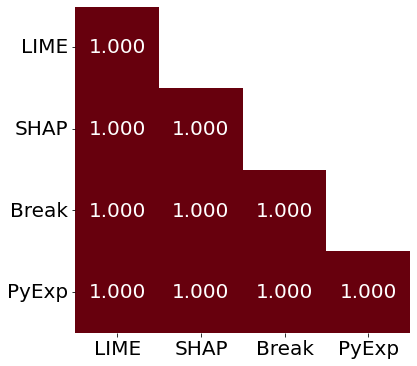

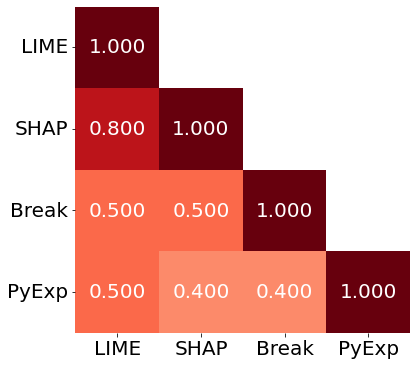

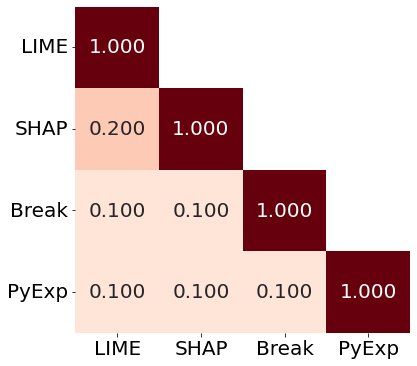

In [22]:
metrics = ['Feature Agreement', 'Sign Agreement', 'Rank Agreement']
metrics_short = ['FA', 'SA', 'RA']
methods = ["LIME", "SHAP", "Break", "PyExp"]
mask = np.array([[0, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 1], [0, 0, 0, 0]])

plt.rcParams['font.size'] = 20

# Compute disagreement matrix
for k, metric in enumerate(metrics):

    plt.figure(figsize=(6, 6))
    df = pd.DataFrame(disagreements[..., k], columns=methods, index=methods)
    # Plot heatmap
    sns.heatmap(df, mask=mask, annot=True, fmt=".3f", cmap='Reds', cbar=False,
                vmin=0, vmax=1, cbar_kws={"shrink": .8})
    # yticks
    plt.yticks(rotation=0)
    plt.savefig(os.path.join("temp_results", f"Disagreement_{metrics_short[k]}_k={k_select}_Corr.pdf"), bbox_inches='tight')
plt.show()